1. Get the data open

In [246]:
!pip install Pillow
!pip install pypng
!pip install scikit-image

Cleaning up...
Cleaning up...
Downloading/unpacking scikit-image
  Running setup.py (path:/tmp/pip_build_root/scikit-image/setup.py) egg_info for package scikit-image
    Cython not found; falling back to pre-built geometry.c
    Cython not found; falling back to pre-built transform.c
    Cython not found; falling back to pre-built _draw.c
    Cython not found; falling back to pre-built corner_cy.c
    Cython not found; falling back to pre-built censure_cy.c
    Cython not found; falling back to pre-built orb_cy.c
    Cython not found; falling back to pre-built brief_cy.c
    Cython not found; falling back to pre-built _texture.c
    Cython not found; falling back to pre-built _hessian_det_appx.c
    Cython not found; falling back to pre-built _unwrap_1d.c
    Cython not found; falling back to pre-built _unwrap_2d.c
    Cython not found; falling back to pre-built _unwrap_3d.c
    Cython not found; falling back to pre-built _denoise_cy.c
    Cython not found; falling back to pre-built _

In [343]:
import re
import numpy as np
import h5py
import PIL
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw, ImageOps
from IPython.display import Image as Image2
import IPython.display
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline



In [82]:
# container-specific paths
forms_hdf5_path="/fileserver/iam/iam-processed/forms/forms.hdf5"
lines_hdf5_path="/fileserver/iam/iam-processed/lines/lines.hdf5"


In [83]:
# get form image from hdf5 file
form_hdf5 = h5py.File(forms_hdf5_path, "r")

In [235]:
def get_form_image(form_id):
    forms_path = '/fileserver/iam/forms/{}.png'
    img = Image.open(forms_path.format(form_id))
    img_array = np.asarray(img)
    return img_array

def get_png_from_array(data):
    buf = io.BytesIO()
    w = png.Writer(*data.shape[::-1], greyscale=True)
    w.write(buf, data)
    return buf.getvalue()

def iam_get_text_block(form_id):
    """Recover coordinates of the hadnwriting part for an IAM form"""
    forms_path= '/fileserver/iam/forms/{}.png'
    lines_txt_path = '/fileserver/iam/lines.txt'
    eight_space_re=re.compile(r'(([^s]+\s){7}).*')
    form_left, form_top, form_right, form_bottom = None, None, None, None
    with open(lines_txt_path, 'r') as lines_data:
        for line_line in lines_data:
            if line_line.startswith(form_id):
                line_line_chopped = eight_space_re.sub('\\1', line_line).strip()
                try:
                    line_id, errcode, graylvl, num_components, left, top, width, height = line_line_chopped.split(' ')
                except ValueError:
                    # malformed line
                    pass
                left = int(left); top = int(top); width = int(width); height=int(height)
                if form_top is None: # or top < form_top_left[1]:
                    form_top = top
                    form_left = left
                    form_bottom = top+height
                    form_right = left+width
                else:
                    form_top = min(top, form_top)
                    form_left = min(left, form_left)                
                    form_bottom = max(top+height, form_bottom)
                    form_right = max(left+width, form_right)
                 
    return form_left, form_top, form_right, form_bottom
            
    

In [236]:
# demonstrate difference between using line sample and reading from form image
line_box = (408, 746, 1661, 89)
line_coords = line_box[:2] + (line_box[0] + line_box[2], line_box[1] + line_box[3])
form_id = 'a01-000u'
line_id = 'a01-000u-00'

print iam_get_text_block(form_id)

['a01-000u-00', 'ok', '154', '19', '408', '746', '1661', '89']
a01-000u-00 408 746 1661 89
['a01-000u-01', 'ok', '156', '19', '395', '932', '1850', '105']
a01-000u-01 395 932 1850 105
['a01-000u-02', 'ok', '157', '16', '408', '1106', '1986', '105']
a01-000u-02 408 1106 1986 105
['a01-000u-03', 'err', '156', '23', '430', '1290', '1883', '70', 'M']
a01-000u-02 408 1106 1986 105
['a01-000u-04', 'ok', '157', '20', '395', '1474', '1830', '94']
a01-000u-04 395 1474 1830 94
['a01-000u-05', 'err', '156', '21', '379', '1643', '1854', '88']
a01-000u-05 379 1643 1854 88
['a01-000u-06', 'ok', '159', '20', '363', '1825', '2051', '87']
a01-000u-06 363 1825 2051 87
(363, 746, 2414, 1912)


In [237]:
line_hdf5 = h5py.File(lines_hdf5_path, "r")
dpi = 80.0

line_img = line_hdf5[line_id]
fig = plt.figure(figsize=(line_img.shape[1]/dpi, line_img.shape[0]/dpi), dpi=dpi)
fig.figimage(line_img)
plt.show()

In [241]:
form_data = get_form_image(form_id)
line_data= form_data[line_coords[1]:line_coords[3],line_coords[0]:line_coords[2]]
hw_coords = iam_get_text_block(form_id)
hw_data = form_data[hw_coords[1]:hw_coords[3],hw_coords[0]:hw_coords[2]]

['a01-000u-00', 'ok', '154', '19', '408', '746', '1661', '89']
a01-000u-00 408 746 1661 89
['a01-000u-01', 'ok', '156', '19', '395', '932', '1850', '105']
a01-000u-01 395 932 1850 105
['a01-000u-02', 'ok', '157', '16', '408', '1106', '1986', '105']
a01-000u-02 408 1106 1986 105
['a01-000u-03', 'err', '156', '23', '430', '1290', '1883', '70', 'M']
a01-000u-02 408 1106 1986 105
['a01-000u-04', 'ok', '157', '20', '395', '1474', '1830', '94']
a01-000u-04 395 1474 1830 94
['a01-000u-05', 'err', '156', '21', '379', '1643', '1854', '88']
a01-000u-05 379 1643 1854 88
['a01-000u-06', 'ok', '159', '20', '363', '1825', '2051', '87']
a01-000u-06 363 1825 2051 87


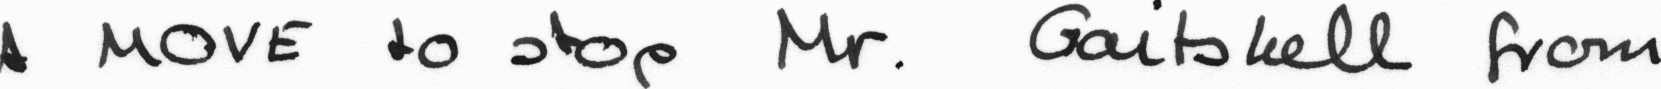

In [239]:
Image2(get_png_from_array(line_data))

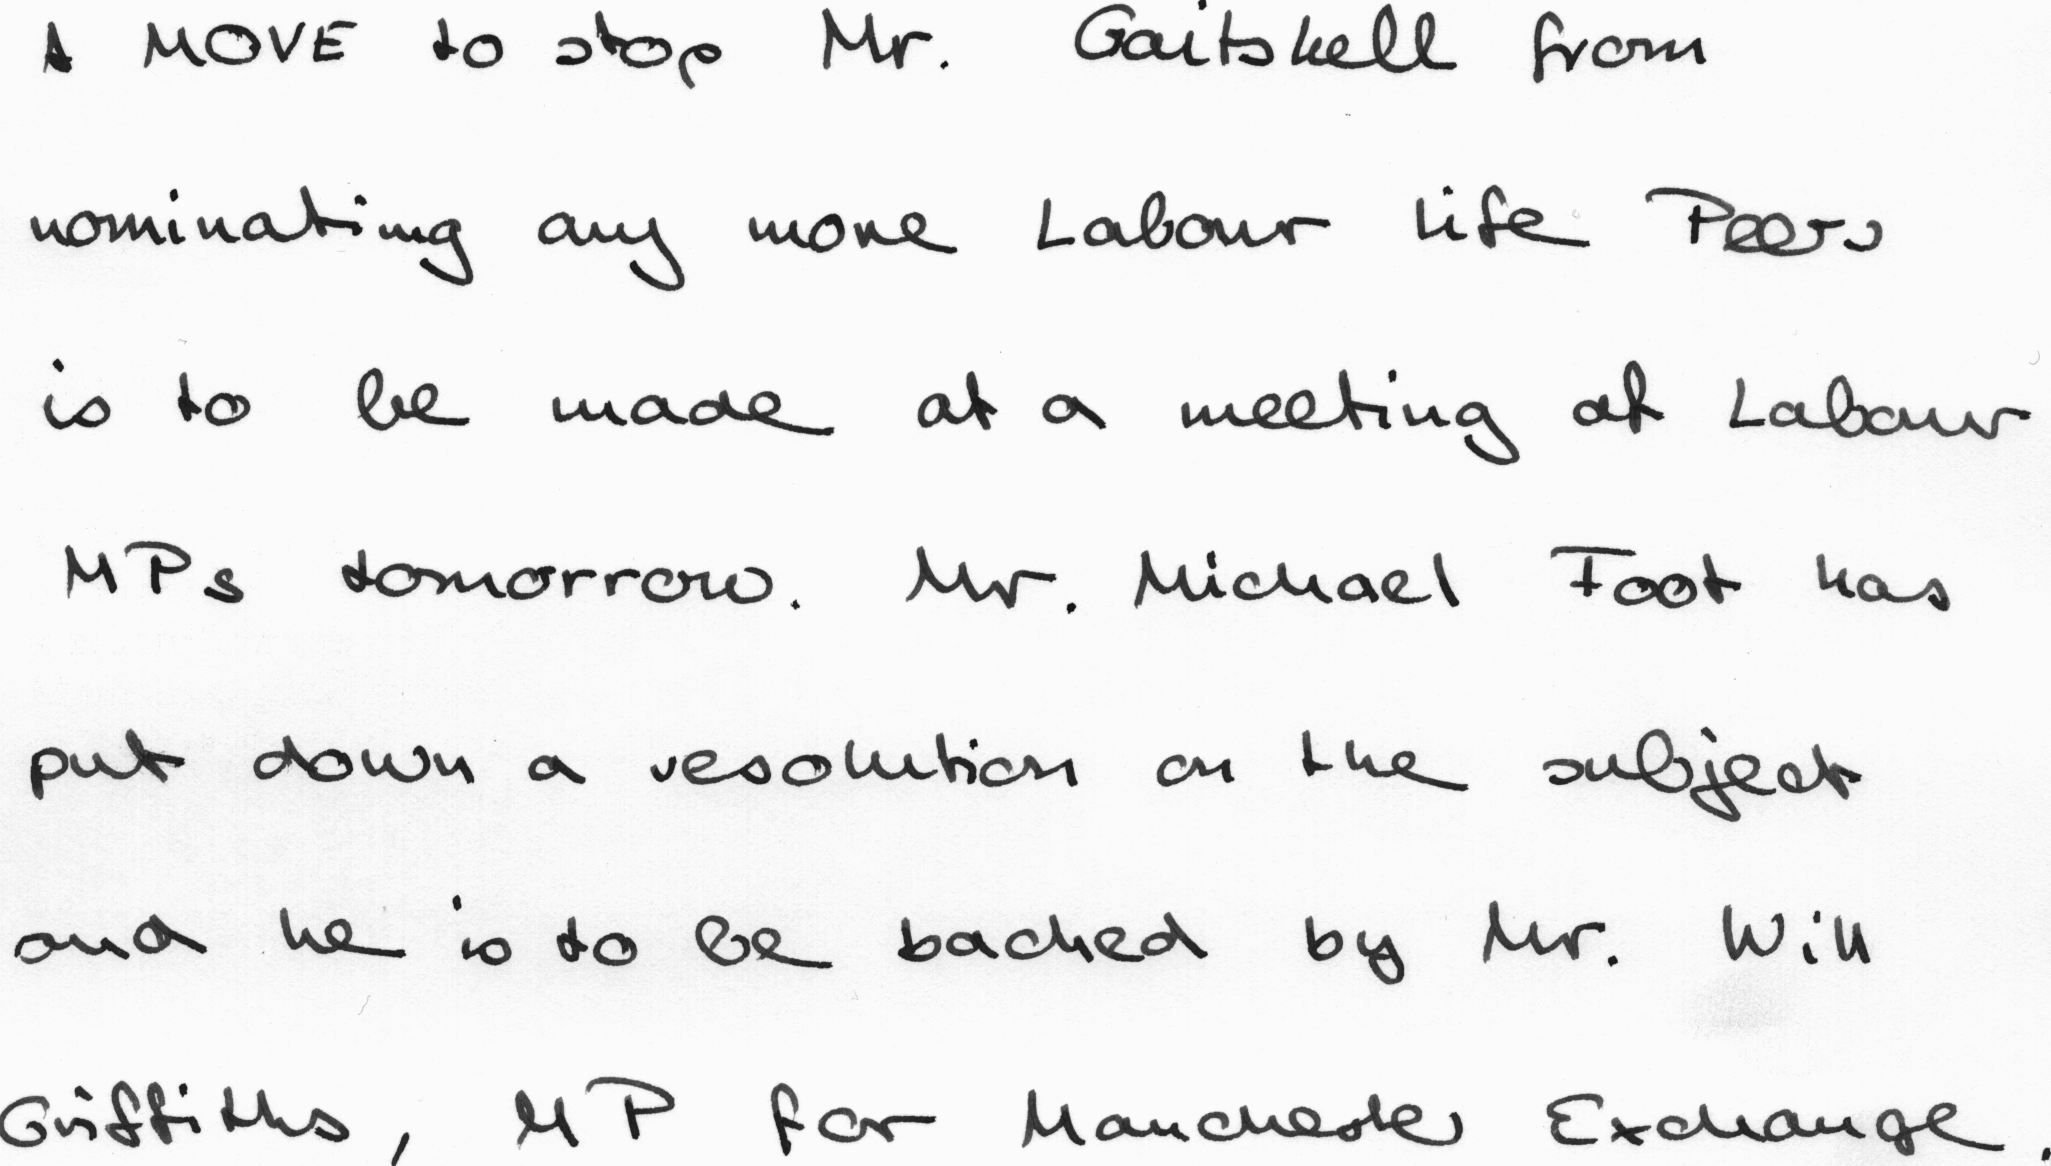

In [243]:
Image2(get_png_from_array(hw_data))

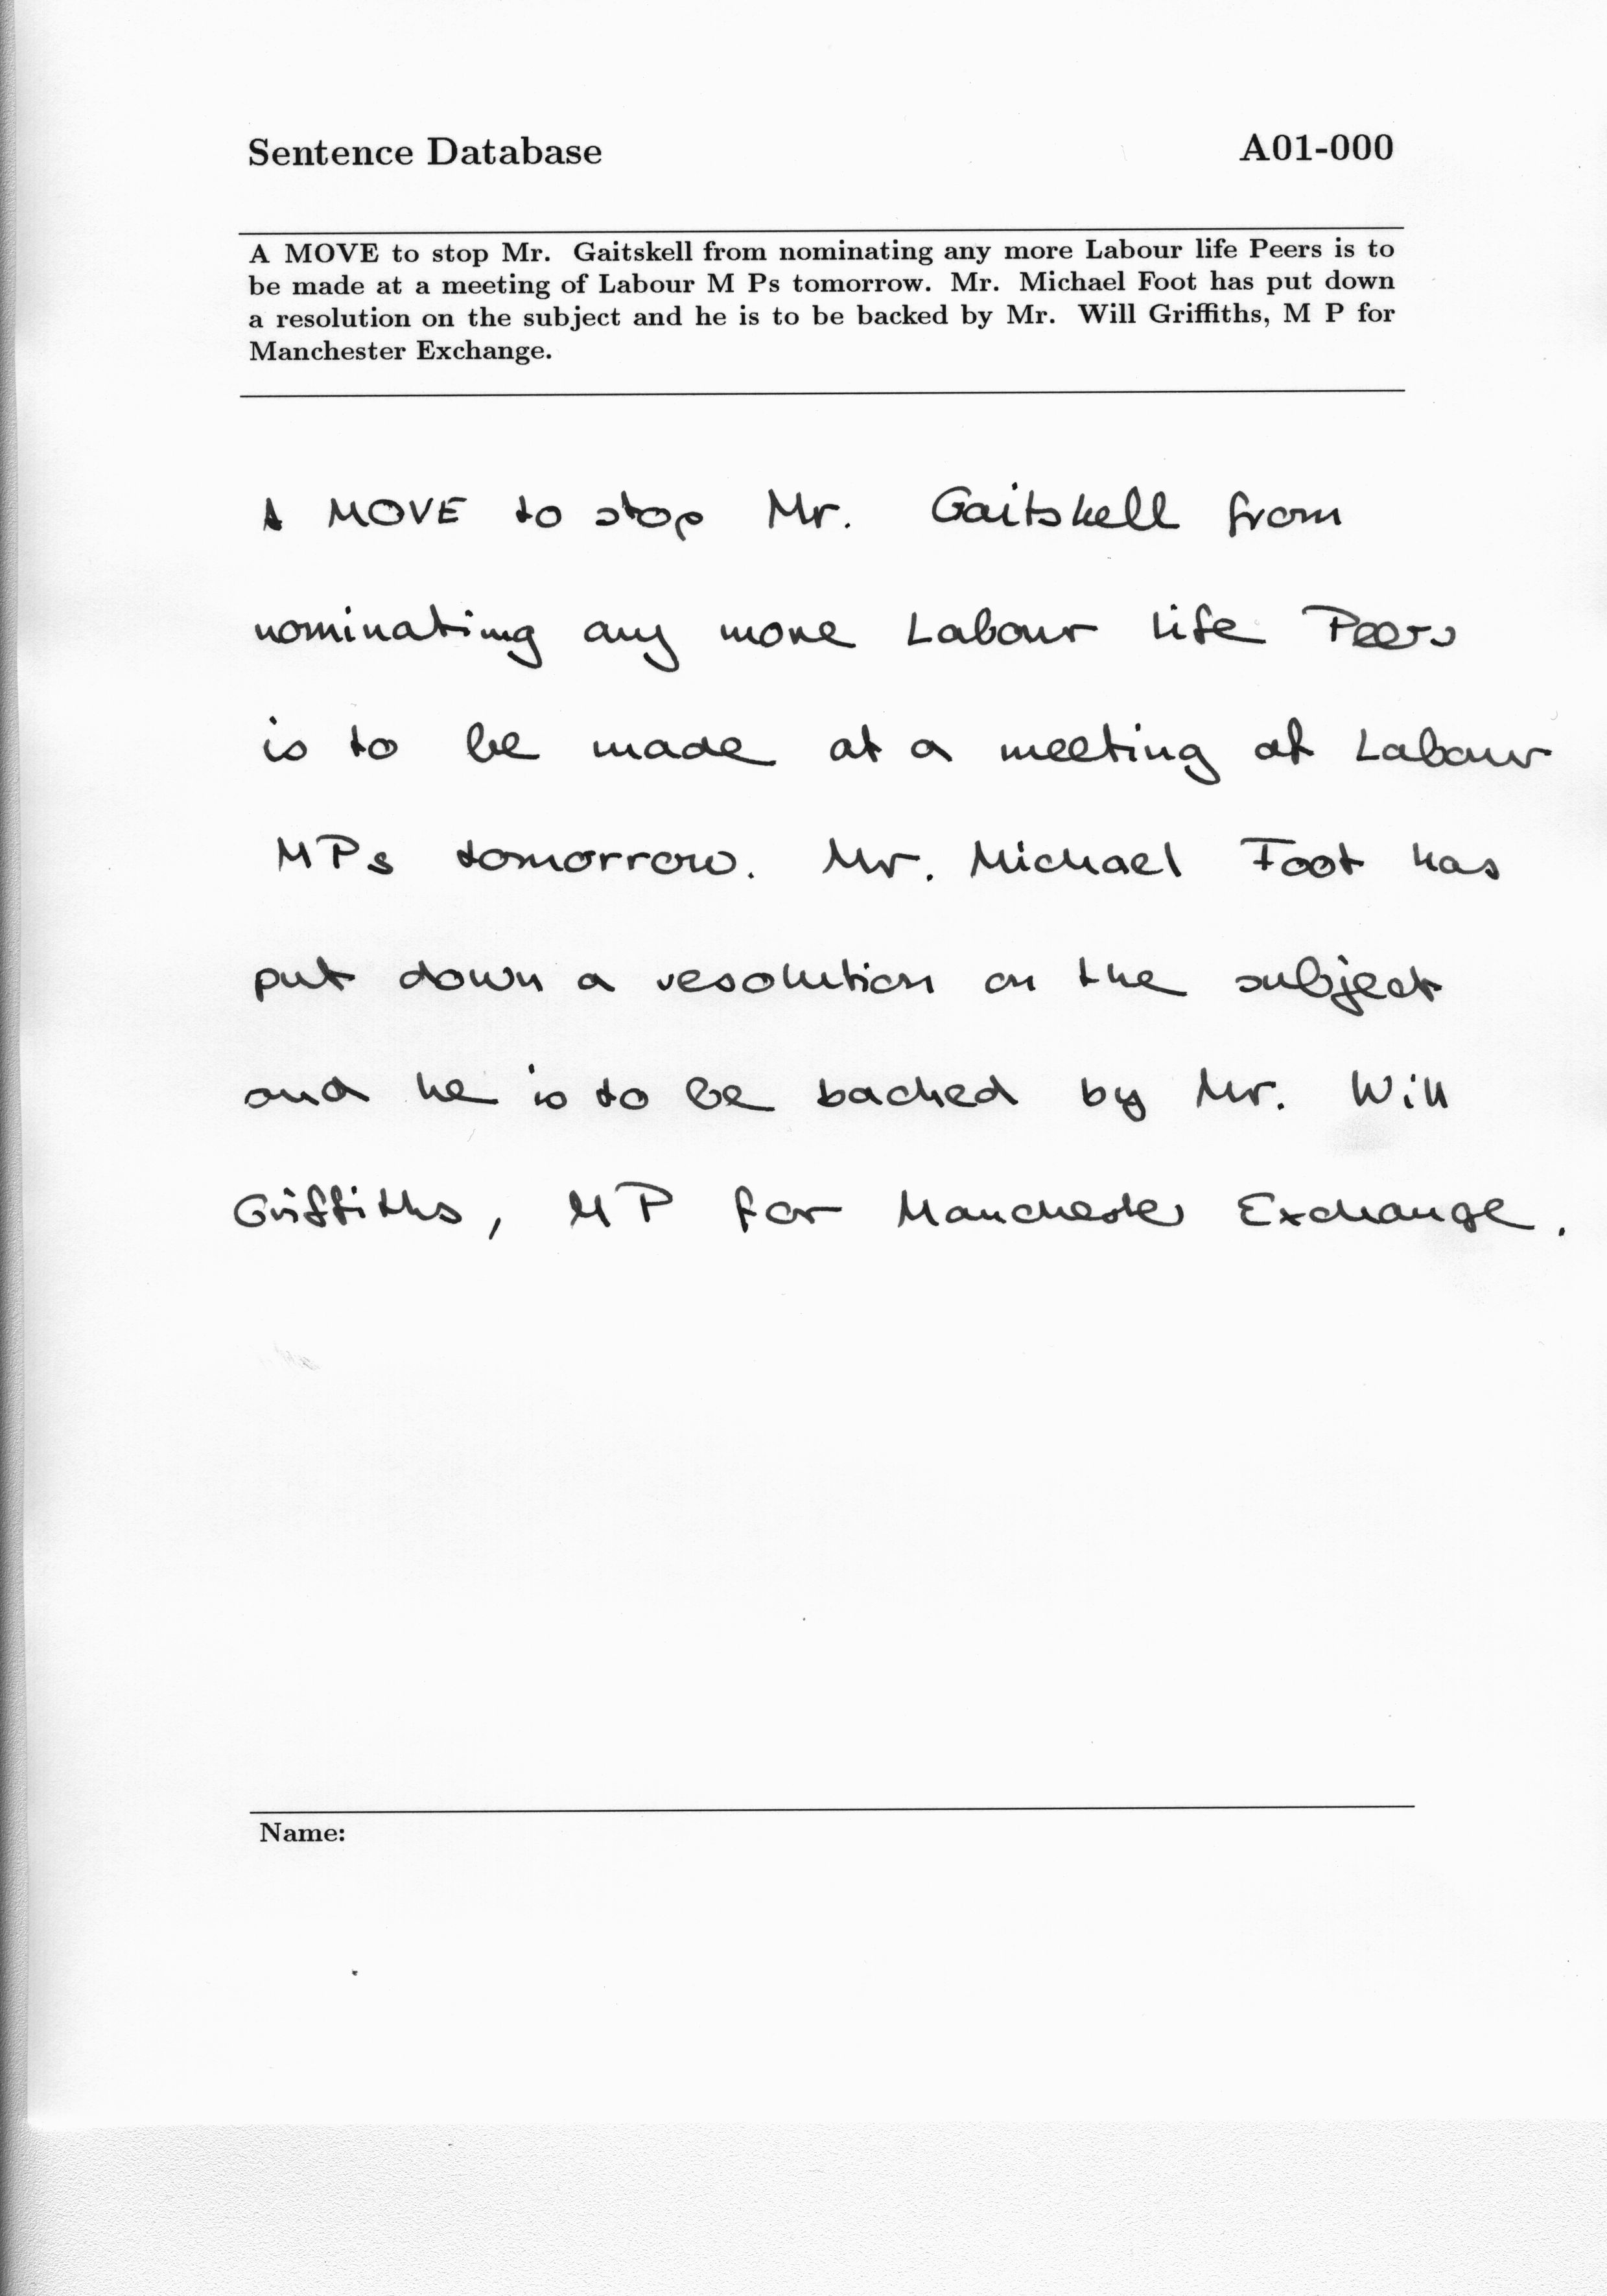

In [240]:
Image2(get_png_from_array(form_data))

In [335]:
hw_image = Image.fromarray(hw_data)
# quadrilateral transform
quad_image = hw_image.transform((300,300), Image.QUAD, (10, 67, 30, 500, 250, 490, 1075, 25))

# affine transformation
aff_image = hw_image.transform(hw_data.shape, Image.AFFINE, (1., 0.5, 0., 
                                                         0., 1., 0.))

# perspective transform
for i, py in enumerate(float(n)*1e-4 for n in range(10)):
    persp_image = hw_image
    persp_image = persp_image.transform(hw_data.shape[::-1], Image.AFFINE,
                                       (1., 0., hw_data.shape[1]/2,
                                       0., 1., 0.))
    persp_image.save("transform_y_{}a.png".format(i))
    persp_image = persp_image.transform(tuple(int(v) for v in hw_data.shape[::-1]), Image.PERSPECTIVE, 
                                     (1., 0.0, 0., 
                                      0.0, 1., 0., 
                                      0., py))
    persp_image.save("transform_y_{}b.png".format(i))
    persp_image = persp_image.transform(hw_data.shape[::-1], Image.AFFINE,
                                       (1., 0., -hw_data.shape[1]/2,
                                       0., 1., 0.))

    persp_image.save("transform_y_{}c.png".format(i))
    im = np.asarray(persp_image.getdata()).reshape(persp_image.size[::-1])
    persp_image.save("transform_y_{}final.png".format(i))

#Image2(get_png_from_array(im))

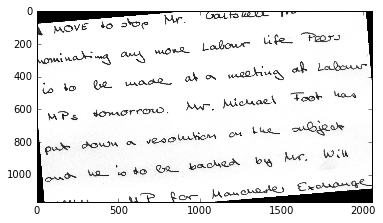

In [394]:
# RegMark images
def apply_reg_marks(img, mark_size=75):
    img=img.convert("L")
    heart = Image.open("heart.png").convert("L")
    spade = Image.open("spade.png").convert("L")
    club = Image.open("club.png").convert("L")
    diamond = Image.open("diamond.png").convert("L")
    
    # add some white bands around input image
    new_img=Image.new("L", [v + 2*int(mark_size*1.1) for v in img.size])
    new_img.paste(255)
    new_img.paste(img, (int(mark_size*1.1),int(mark_size*1.1)))
    img=new_img
    
    # paste reg marks
    img.paste(heart.resize((mark_size,mark_size)), (10, 10), mask=ImageOps.invert(heart.resize((mark_size,mark_size))))
    img.paste(spade.resize((mark_size,mark_size)), (img.size[0]-mark_size-10, 10), mask=ImageOps.invert(spade.resize((mark_size,mark_size))))
    img.paste(club.resize((mark_size,mark_size)), (10, img.size[1]-mark_size), mask=ImageOps.invert(club.resize((mark_size,mark_size))))
    img.paste(diamond.resize((mark_size,mark_size)), (img.size[0]-mark_size-10, img.size[1]-mark_size-10), mask=ImageOps.invert(diamond.resize((mark_size,mark_size))))
    return img
    
img=apply_reg_marks(hw_image)
imshow(img)


def randangle(im):
    imangle = np.asarray(Image.fromarray(im.squeeze()).rotate(7.5*np.random.randn()))
    return imangle

imshow(randangle(hw_data))